# 2021-09-16 Introducing value squashing

Results below are for commit: 

(Rerunning the code below for other commits is not guaranteed to give the same results.)

* First just verified that before changing anything I am still able to generate the nice sequence of behaviours for `oBEo`, adding `oBEv`, then adding `oAI`, as described in the diary notes both from 2021-08-26 and 2021-09-08. A little worried that this nice stuff will disappear when I introduce the value squashing... :)
* Introduced tanh sigmoid value squashing with scale $V_0 = V_\mathrm{0,rel} \cdot V_\mathrm{free}$, where $V_\mathrm{free}$ is the value for the agent of locomoting at its free speed, without any interaction at all. Here, I am setting $V_\mathrm{0,rel} = 4$, meaning that the squashed value of free locomotion is 0.25, sort of in the middle of the range within which tanh is near-linear.

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:89: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Unit tests, reproducing earlier results

Just the base model, no interaction. Also plotting action value estimates here, to show that the value of non-action converges to near 0.25, as expected. (It doesn't converge exactly because the model might not be able to reach the free speed exactly.) 

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


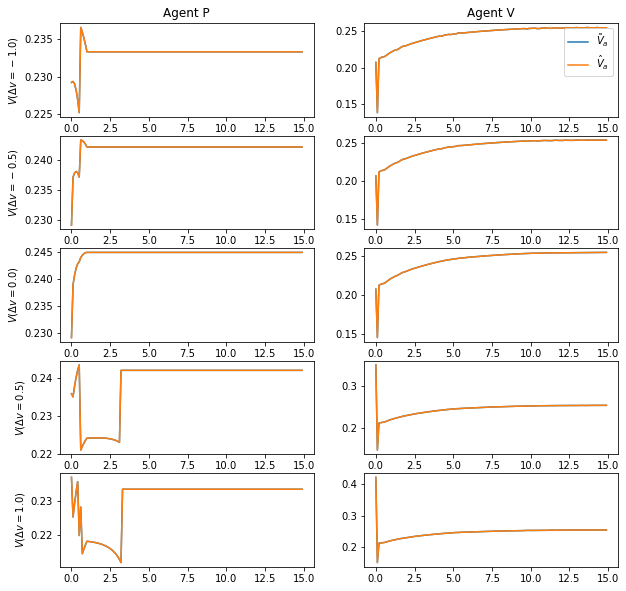

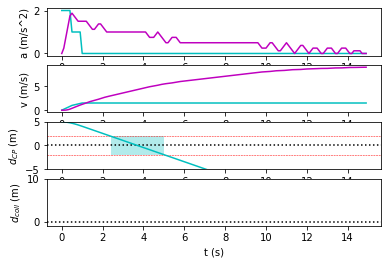

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, action_val_ests = True)

Baseline kinematics, base model. Quite unexpectedly for me, this still yields the same output as before adding the value squashing... But when I think further about it I shouldn't be so surprised, because the value squashing doesn't change the order of values for different actions, which is all that matters for the base model.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 30 m:


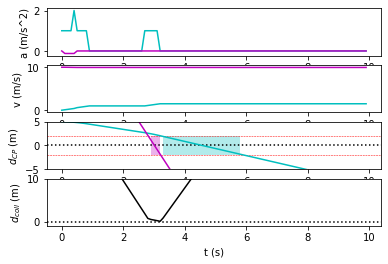

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


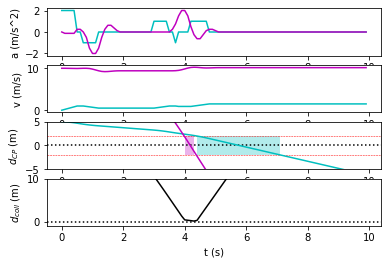

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 50 m:


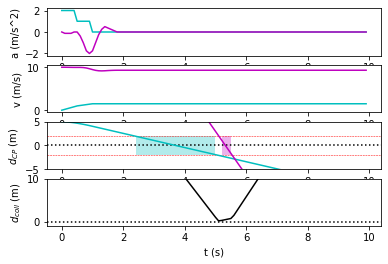

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs)

run_baseline_kinematics()

## The `oBEo` + `oBEv` + `oAI` sequence

Turning on `oBEo`, we get the same results as before adding the value squashing. Makes sense.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


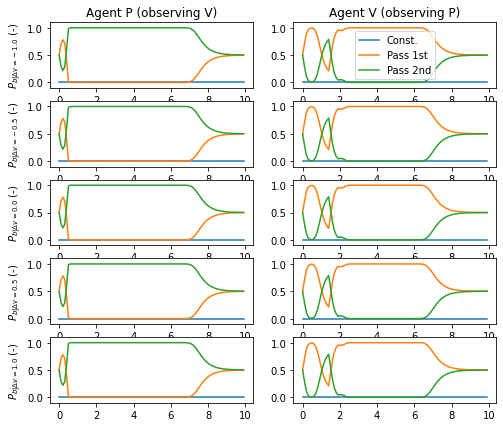

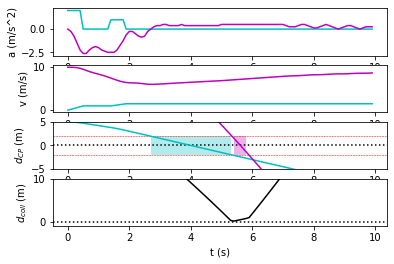

In [4]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
params.T_O = 0.5
params.sigma_O = 0.01
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)

However, now adding `oBEv` doesn't make any difference to the `oBEo` only simulation - which is not how it was previously. We can see below that this is because the value squashing has changed the scale of the values, and we haven't (yet) adjusted $\beta_\mathrm{V}$ from its default value of one. 

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


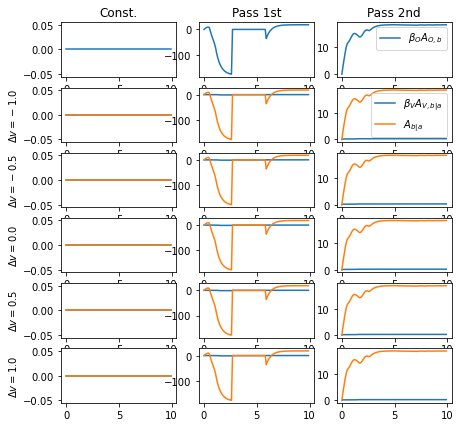

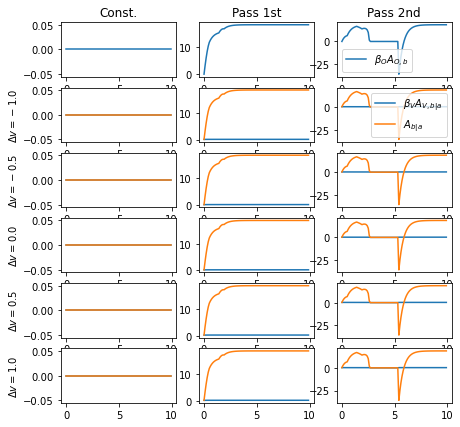

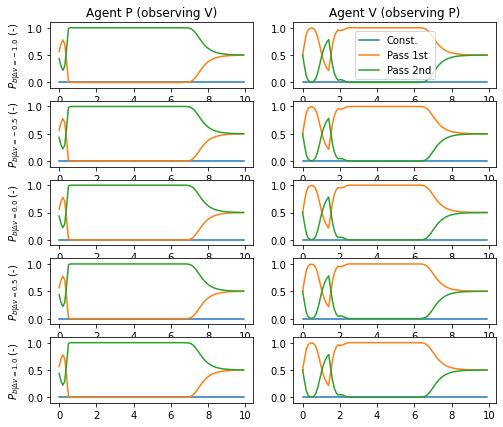

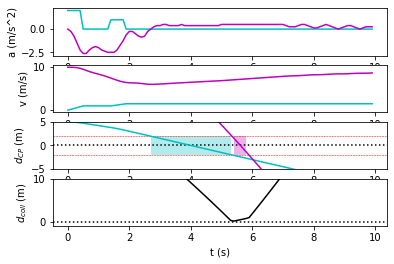

In [5]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
params.T_O = 0.5
params.sigma_O = 0.01
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_activs = True)

The unsquashed value of free locomotion (with the default parameters) is about 40, and now after squashing it is 0.25, which is a factor 160, and we use that as our value for $\beta_\mathrm{V}$ we get back identical or very similar behaviour to before:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


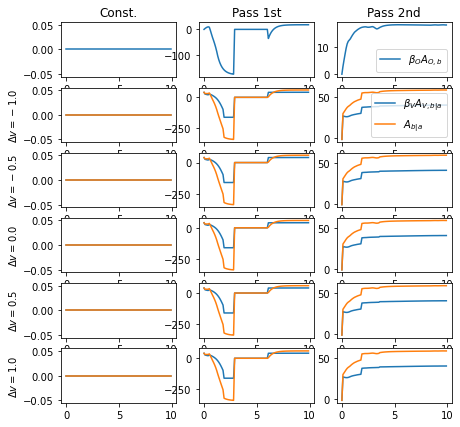

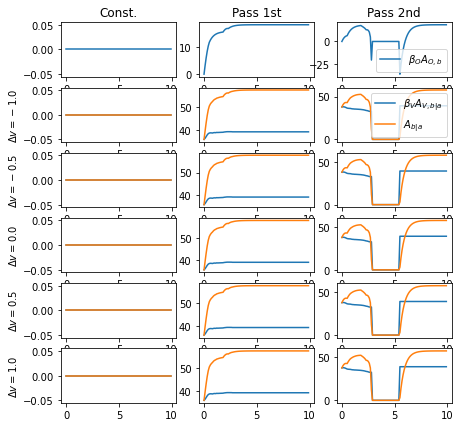

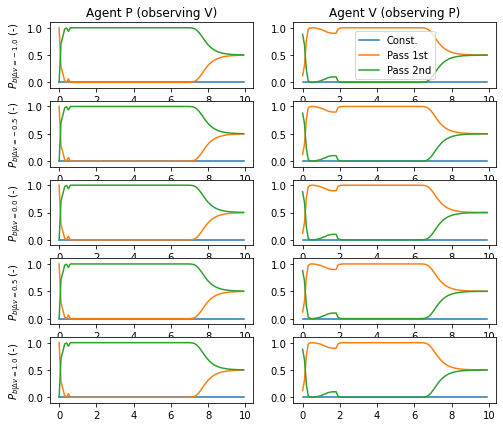

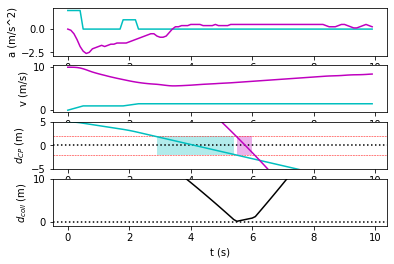

In [12]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
params.beta_V = 160
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_activs = True)

And also when adding in `oAI` (actually the estimated impact of own actions on the other's behaviour are slightly bigger than previous, but the resulting behaviour is very similar to the earlier simulations without squashing; see, e.g., 2021-08-26):

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


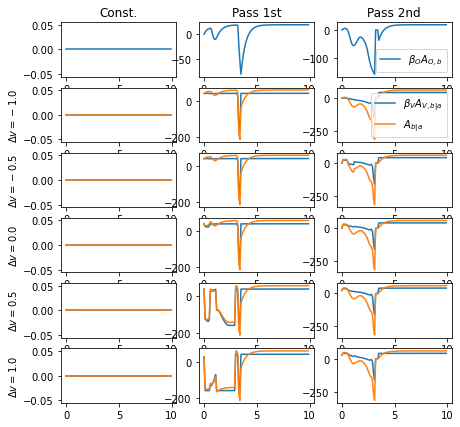

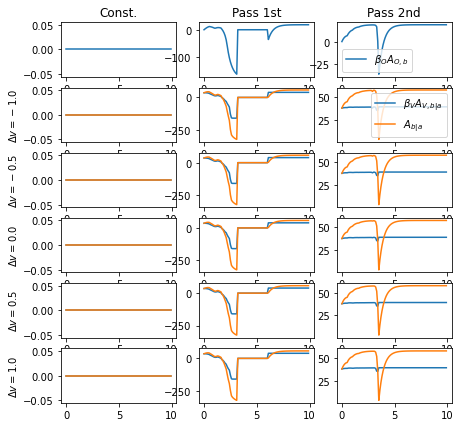

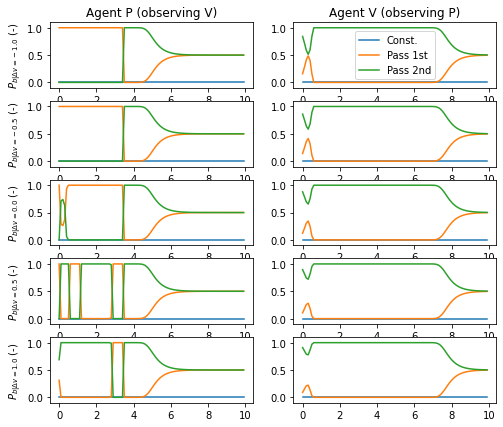

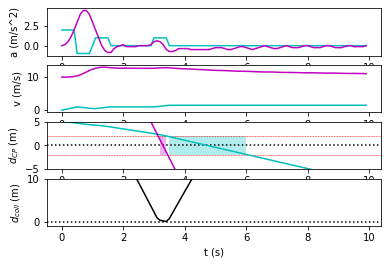

In [13]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_activs = True)

One thing to note is that $\beta_\mathrm{V} = 160$ seems quite a bit higher than I envisioned, based on my thinking in the 2021-09-10 diary notes, because it corresponds to a very very small $P_\dagger$:

In [8]:
import math
P_cross = 1 / (1 + math.exp(160))
print(P_cross)

3.257488532207521e-70


And in one sense a really small number is sort of ok I guess, given that it is supposed to be the probability of doing something suicidally stupid, but at the same time that number suggests that no humans should ever do anything suicidally stupid, which seems untrue. On the other hand, doing suicidally stupid stuff might more often than not be about having incomplete information, and I guess $P_\dagger$ rather represents the probability of doing it despite having complete and perfect information about how suicidally stupid it is. 

In either case, it seems like it will make a lot of difference to the model whether $P_\dagger = 10^{-100}$ or $P_\dagger = 10^{-200}$, so it seems I might not be able to use "intuitively reasonable" values for $P_\dagger$, as I hoped. Some example corresponding $\beta_\mathrm{V}$s, until we run out of machine precision:

In [9]:
for P_cross in (1e-2, 1e-5, 1e-50, 1e-100, 1e-200, 1e-400):
    beta_V = math.log((1-P_cross)/P_cross)
    print(f'P_cross = {P_cross} => beta_V = {beta_V:.1f}')

P_cross = 0.01 => beta_V = 4.6
P_cross = 1e-05 => beta_V = 11.5
P_cross = 1e-50 => beta_V = 115.1
P_cross = 1e-100 => beta_V = 230.3
P_cross = 1e-200 => beta_V = 460.5


ZeroDivisionError: float division by zero

Just to verify, here is a simulation with $P_\dagger = 10^{-5}$, which is sort of at the edge of the range of probabilities I would consider that one could reason about "intuitively", and as can be seen, the prior probabilities (at time t = 0 s) are markedly different from fifty-fifty, but with the current parameterisation of the action observation, the action observations quickly overpower what the value estimates are saying, such that after a few tenths of a second, the model is essentially purely a `oBEo` model.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:202: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


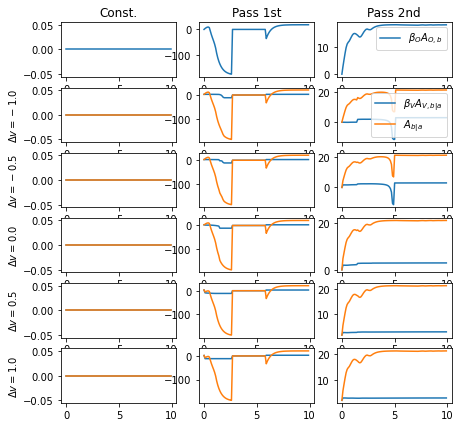

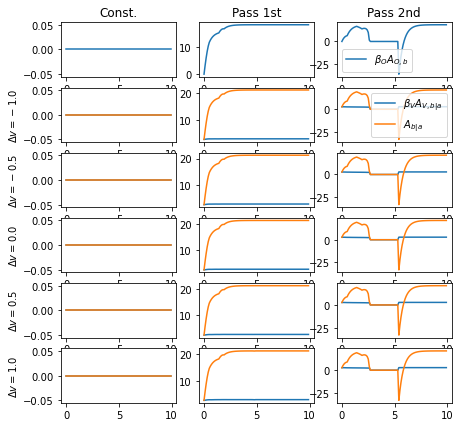

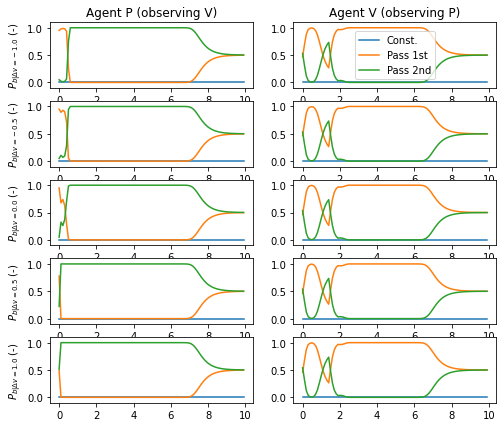

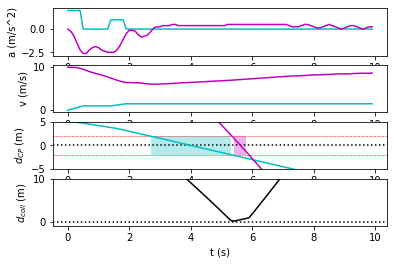

In [10]:
params.beta_V = 11.5
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_activs = True)

Good next steps might be about tweaking the `oBEo` settings a bit then - after having updated the implementation to be fully in line with the 2021-09-10 formulation.